In [1]:
import numpy as np
from scipy.integrate import odeint


class Kuramoto:

    def __init__(self, coupling=1, dt=0.01, T=10, n_nodes=None, natfreqs=None):
        '''
        coupling: float
            Coupling strength. Default = 1. Typical values range between 0.4-2
        dt: float
            Delta t for integration of equations.
        T: float
            Total time of simulated activity.
            From that the number of integration steps is T/dt.
        n_nodes: int, optional
            Number of oscillators.
            If None, it is inferred from len of natfreqs.
            Must be specified if natfreqs is not given.
        natfreqs: 1D ndarray, optional
            Natural oscillation frequencies.
            If None, then new random values will be generated and kept fixed
            for the object instance.
            Must be specified if n_nodes is not given.
            If given, it overrides the n_nodes argument.
        '''
        if n_nodes is None and natfreqs is None:
            raise ValueError("n_nodes or natfreqs must be specified")

        self.dt = dt
        self.T = T
        self.coupling = coupling

        if natfreqs is not None:
            self.natfreqs = natfreqs
            self.n_nodes = len(natfreqs)
        else:
            self.n_nodes = n_nodes
            self.natfreqs = np.random.normal(size=self.n_nodes)

    def init_angles(self):
        '''
        Random initial random angles (position, "phi").  # Teria que ser position phi
        '''
        return 2 * np.pi * np.random.random(size=self.n_nodes)  # phi eh soh nomenclatura   

    def derivative(self, angles_vec, t, adj_mat):
        '''
        Compute derivative of all nodes for current state
        t: for compatibility with scipy.odeint
        '''
        assert len(angles_vec) == len(self.natfreqs) == len(adj_mat), \
            'Input dimensions do not match, check lengths'

        angles_i, angles_j = np.meshgrid(angles_vec, angles_vec)
        dxdt = self.natfreqs + self.coupling / adj_mat.sum(axis=0) \
               * (adj_mat * np.sin(angles_j - angles_i)).sum(axis=0) # count incoming neighbors
        return dxdt

    def integrate(self, angles_vec, adj_mat):
        '''Updates all states by integrating state of all nodes'''
        t = np.linspace(0, self.T, int(self.T/self.dt))  # self.T == Total time of simulated activity.
        timeseries = odeint(self.derivative, angles_vec, t, args=(adj_mat,))
        return timeseries.T  # transpose for consistency (act_mat:node vs time)

    def run(self, adj_mat=None, angles_vec=None): # teria que angles_vec = phi
        '''
        adj_mat: 2D nd array
            Adjacency matrix representing connectivity.
        angles_vec: 1D ndarray, optional
            States vector of nodes representing the position in radians.
            If not specified, random initialization [0, 2pi].
        Returns
        -------
        act_mat: 2D ndarray
            Activity matrix: node vs time matrix with the time series of all
            the nodes.
        '''
        assert (adj_mat == adj_mat.T).all(), 'adj_mat must be symmetric'  #B1

        if angles_vec is None:
            angles_vec = self.init_angles()

        return self.integrate(angles_vec, adj_mat) # gera matrix de incidencia. Teria que botar um passo a mais p gerar B2
    
    # Precisamos adaptar a funcao para somar as equacoes
    
    @staticmethod
    def phase_coherence(angles_vec):
        '''
        Compute global order parameter R_t - mean length of resultant vector
        '''
        suma = sum([(np.e ** (1j * i)) for i in (B1*angles_vec)]) # temos Ro, pra R1 down precisamos B1*phi, R1up=B2.T*phi .. Sendo B2 a matrix com triangulos
        return abs(suma / len(angles_vec))  # Adaptar para quantidade de triangulos para R1up

    def mean_frequency(self, act_mat, adj_mat):
        '''
        Compute average frequency within the time window (self.T) for all nodes
        '''
        assert len(adj_mat) == act_mat.shape[0], 'adj_mat does not match act_mat'
        _, n_steps = act_mat.shape

        # Compute derivative for all nodes for all time steps
        dxdt = np.zeros_like(act_mat)
        for time in range(n_steps):
            dxdt[:, time] = self.derivative(act_mat[:, time], None, adj_mat)

        # Integrate all nodes over the time window T
        integral = np.sum(dxdt * self.dt, axis=1)
        # Average across complete time window - mean angular velocity (freq.)
        meanfreq = integral / self.T
        return meanfreq

    # The following functions are redundant, they're just more pure python
    # implementations (and less efficient) in order to test the code.
    def _derivative_purepython(self, angles_vec, adj_mat):
        '''Compute derivative for current state'''

        assert len(angles_vec) == len(self.natfreqs) == len(adj_mat), \
            'Input dimensions do not match, check lengths'

        dxdt = np.zeros_like(self.natfreqs)
        for node in range(self.n_nodes):
            # Add sumation term
            dxdt[node] = sum([np.sin(angles_vec[j] - angles_vec[node])
                              for j in np.where(adj_mat[:, node])[0]])
        # Scale by coupling and interactions
        dxdt *= self.coupling/adj_mat.sum(axis=0)
        # Natural freq term
        dxdt += self.natfreqs
        return dxdt

    def _integrate_purepython(self, angles_vec, adj_mat):
        '''Updates all states by integrating state of all nodes'''
        dxdt = self._derivative_purepython(angles_vec, adj_mat)
        return angles_vec + dxdt*self.dt

    def _run_purepython(self, angles_vec=None, adj_mat=None):
        '''
        Integrate by hand each step (instead of using scipy.odeint)
        adj_mat: 2D nd array
            Adjacency matrix representing connectivity.
        angles_vec: 1D ndarray
            States vector of nodes representing the position in radians.
        Returns
        -------
        act_mat: 2D ndarray
            Activity matrix: node vs time matrix with the time series of all
            the nodes.
        '''
        if angles_vec is None:
            angles_vec = self.init_angles()

        n_tot_steps = int(self.T/self.dt)
        act_mat = np.zeros((self.n_nodes, n_tot_steps))
        act_mat[:, 0] = angles_vec

        for timestep in range(n_tot_steps-1):
            act_mat[:, timestep+1] = self._integrate_purepython(act_mat[:, timestep],
                                                                adj_mat)
        return act_mat

# Part 2

In [2]:
%matplotlib inline

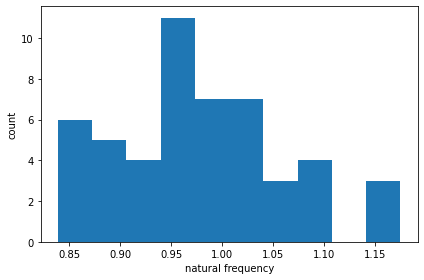

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

# Instantiate a random graph and transform into an adjacency matrix
n_nodes = 50 
graph_nx = nx.erdos_renyi_graph(n=n_nodes, p=1) # p=1 -> all-to-all connectivity
graph = nx.to_numpy_array(graph_nx)

# Run model with different coupling (K) parameters
coupling_vals = np.linspace(0, 0.6, 100)
runs = []
for coupling in coupling_vals:        
    model = Kuramoto(coupling=coupling, dt=0.1, T=500, n_nodes=n_nodes) 
    model.natfreqs = np.random.normal(1, 0.1, size=n_nodes)  # reset natural frequencies
    act_mat = model.run(adj_mat=graph)   
    runs.append(act_mat)

# Check that natural frequencies are correct (we need them for prediction of Kc)
plt.figure()
plt.hist(model.natfreqs)
plt.xlabel('natural frequency')
plt.ylabel('count')
plt.tight_layout()

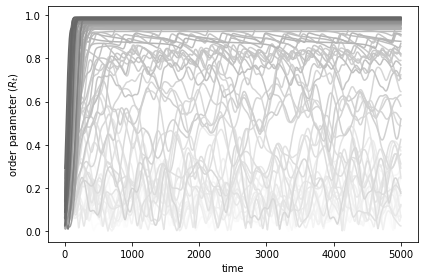

In [5]:
# Plot all time series for all coupling values (color coded)
runs_array = np.array(runs)

plt.figure()
for i, coupling in enumerate(coupling_vals):
    plt.plot(
        [model.phase_coherence(vec)
         for vec in runs_array[i, ::].T],
        c=str(1-coupling),  # higher -> darker   
    )
plt.ylabel(r'order parameter ($R_t$)')
plt.xlabel('time')
plt.tight_layout()

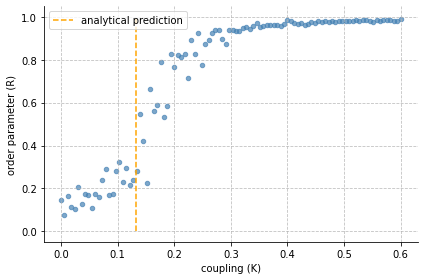

In [6]:
# Plot final Rt for each coupling value
plt.figure()
for i, coupling in enumerate(coupling_vals):
    r_mean = np.mean([model.phase_coherence(vec)
                      for vec in runs_array[i, :, -1000:].T]) # mean over last 1000 steps
    plt.scatter(coupling, r_mean, c='steelblue', s=20, alpha=0.7)

# Predicted Kc – analytical result (from paper)
Kc = np.sqrt(8 / np.pi) * np.std(model.natfreqs) # analytical result (from paper)
plt.vlines(Kc, 0, 1, linestyles='--', color='orange', label='analytical prediction')

plt.legend()
plt.grid(linestyle='--', alpha=0.8)
plt.ylabel('order parameter (R)')
plt.xlabel('coupling (K)')
sns.despine()
plt.tight_layout()